In [2]:
import time
import pandas as pd
import numpy as np
import datetime as datetime
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import skew
from scipy.stats import kurtosis
%matplotlib inline

# User Inputs

In [3]:
# In-sample or Out-sample mode
mode = 'In'

# No. of days that the short position will be held
nd = 5 

# Amount (in USD) of short position in a single bond
amnt = 10**6

# Initial value of the portfolio (in USD)
inival = 0.5*(10**6)

# Risk free rate
risk_free_rate = 0.02

# Basic Implementation('BASIC') or Extension('EXT')
type = 'EXT'

# Borrowing Cost
cost = 0.0/365

# Importing the transaction dataframe
trxdata = pd.DataFrame(pd.read_csv("fa_input1.csv"))
trxdata["Date"] = pd.to_datetime(trxdata["Date"])

# Importing the price matrix of bonds
prmat = pd.DataFrame(pd.read_csv("fa_input2.csv"))
prmat["Date"] = pd.to_datetime(prmat["Date"])

# Importing the price matrix of the hedge
hprmat = pd.DataFrame(pd.read_csv("fa_input3.csv"))
hprmat["Date"] = pd.to_datetime(hprmat["Date"])

# Other Dataframes
trxmat = pd.DataFrame(index=prmat.index, columns=prmat.columns)
trxmat.Date = prmat.Date

portchanges = pd.DataFrame(index=prmat.index, columns=['Date', 'Changes'])
portchanges.Date = prmat.Date

intport = trxmat.copy()
hportchanges = portchanges.copy()
hquantmat = trxmat.copy()
trxmat_temp = trxmat.copy()


# Setting dates for in-sample and out-sample testing
if mode == 'In':
    trxdata = trxdata.loc[trxdata['Date'] < pd.to_datetime('2017-01-01')]
    trxmat = trxmat.loc[trxmat['Date'] < pd.to_datetime('2017-01-01')]
    prmat = prmat.loc[prmat['Date'] < pd.to_datetime('2017-01-01')]
    portchanges = portchanges.loc[portchanges['Date'] < pd.to_datetime('2017-01-01')]
    intport = intport.loc[intport['Date'] < pd.to_datetime('2017-01-01')]
    hportchanges = hportchanges.loc[hportchanges['Date'] < pd.to_datetime('2017-01-01')]
    hquantmat = hquantmat.loc[hquantmat['Date'] < pd.to_datetime('2017-01-01')]
    trxmat_temp = trxmat_temp.loc[trxmat_temp['Date'] < pd.to_datetime('2017-01-01')]
    hprmat = hprmat.loc[hprmat['Date'] < pd.to_datetime('2017-01-01')]
elif mode == 'Out':
    trxdata = trxdata.loc[trxdata['Date'] >= pd.to_datetime('2017-01-01')]
    trxmat = trxmat.loc[trxmat['Date'] >= pd.to_datetime('2017-01-01')]
    prmat = prmat.loc[prmat['Date'] >= pd.to_datetime('2017-01-01')]
    portchanges = portchanges.loc[portchanges['Date'] >= pd.to_datetime('2017-01-01')]
    intport = intport.loc[intport['Date'] >= pd.to_datetime('2017-01-01')]
    hportchanges = hportchanges.loc[hportchanges['Date'] >= pd.to_datetime('2017-01-01')]
    hquantmat = hquantmat.loc[hquantmat['Date'] >= pd.to_datetime('2017-01-01')]
    trxmat_temp = trxmat_temp.loc[trxmat_temp['Date'] >= pd.to_datetime('2017-01-01')]
    hprmat = hprmat.loc[hprmat['Date'] >= pd.to_datetime('2017-01-01')]

# Functions

In [4]:
# Computing quantity of bond and hedging instruments to be traded 
def trxdatafunc():
    trxdata["Quantity"]=(amnt/trxdata["Entry Price"])
    trxdata["H Quantity"]=(trxdata["Entry Price"]*trxdata["Duration"]*trxdata["Quantity"])/(trxdata["H Duration"]*trxdata["H Entry Price"])
    trxdata["Exit Date"] = trxdata["Date"] + datetime.timedelta(days=nd)

In [5]:
# Computing the transaction matrix "trxmat" - Such that it has '1' on all trading days for the appropriate bond. Trading days to include Entry Date and Exit Date in dataframe "td"
def trxmatfunc():    
    for col in trxmat.columns:
        if (col!='Date'):
            trxmat[col].values[:] = 0
            trxmat_temp[col].values[:] = 0
    
    for index,val in trxdata.iterrows():
        temp_entdate = trxdata.loc[index]['Date']
        temp_extdate = trxdata.loc[index]['Exit Date']
        temp_CUSIP = trxdata.loc[index]['CUSIP']
        
        for i in range (0,nd+1):
            single_date = temp_entdate + datetime.timedelta(days=(i))
            myindex = trxmat[trxmat['Date']==single_date].index
            trxmat.at[myindex,temp_CUSIP] = -1
            
        for i in range (1,nd+1):
            single_date = temp_entdate + datetime.timedelta(days=(i))
            myindex = trxmat_temp[trxmat_temp['Date']==single_date].index
            trxmat_temp.at[myindex,temp_CUSIP] = 1

In [6]:
# Compute the Changes to the short portfolio
def portchangesfunc(df1, df2, df4, df5, df6):

    df1.set_index('Date', inplace = True)
    df2.set_index('Date', inplace = True)
    df4.set_index('Date', inplace = True)
    df5.set_index('Date', inplace = True)
    
    intport_temp = pd.DataFrame(df1.values * df2.values * df4.values, index = df1.index)
    intport_temp = intport_temp.fillna(0)
    
    intport_temp = intport_temp.diff()
    
    intport = pd.DataFrame(intport_temp.values * df5.values, index = intport_temp.index)
    
    intport['Changes'] = intport.sum(axis=1)
    intport = intport.reset_index(drop=True)
    intport.index = df6.index
    
    df6['Changes'] = intport['Changes']
    return df6

In [7]:
# Compute the borrowing cost
def borrcostfunc(df1, df2, df4):
    
    intport_temp = pd.DataFrame(df1.values * df2.values * df4.values, index = df1.index)
    intport_temp = intport_temp.fillna(0)
    borrcost_temp = intport_temp * cost
    
    borrcost = pd.DataFrame(index = borrcost_temp.index)
    borrcost['Cost'] = borrcost_temp.sum(axis = 1)
    borrcost = borrcost.reset_index(drop=True)
    borrcost.to_csv("output_bor.csv")
    return borrcost

In [8]:
# Compute the changes to the hedge portfolio
def hedgefunc(df1, df2, df4, df5, df6):
    
    df1.set_index('Date', inplace = True)
    df2.set_index('Date', inplace = True)
    df4.set_index('Date', inplace = True)
    
    hintport_temp = pd.DataFrame(df1.values * df2.values * df4.values, index = df1.index)
    hintport_temp = hintport_temp.fillna(0)
    
    hintport_temp = hintport_temp.diff()
    hintport_temp = hintport_temp * -1
    
    df5.set_index('Date', inplace = True)
    hintport = pd.DataFrame(hintport_temp.values * df5.values, index = hintport_temp.index)
    
    hintport['Changes'] = hintport.sum(axis=1)
    hintport = hintport.reset_index(drop=True)
    hintport.index = df6.index
    df6['Changes'] = hintport['Changes']
    return df6

In [9]:
# Function for calculating the returns
def portfunc(df):
    df_pf = df
    values = [inival]
    value = inival
    for i in range(len(df_pf)):
        value = value + df_pf['Changes'].iloc[i]
        values.append(value)
        
    df_pf['Opening Value'] = values[:-1]
    df_pf['Closing Value'] = values[1:]
    df_pf['Daily Return'] = df_pf['Changes']/df_pf['Opening Value']
    
    cum_return = [1]
    cum_rt = 1
    for i in range(len(df_pf)):
        cum_rt = cum_rt*(1+df_pf['Daily Return'].iloc[i])
        cum_return.append(cum_rt)
    df_pf['Cummulative Return'] = cum_return[1:]
    
    df_pf = df_pf[['Date','Opening Value','Changes','Closing Value','Daily Return','Cummulative Return']]
    df_pf.to_csv("ext nb.csv")
    return df_pf

In [14]:
# Function for calculating maximum drawdown
def maxdrawdown(df):
    df = df.reset_index(drop=True)
    cr = df['Cummulative Return']
    i = np.argmax((np.maximum.accumulate(cr) - cr)/np.maximum.accumulate(cr)) # end of the period
    j = np.argmax(cr[:i]) # start of period
    k = df.iloc[i:]['Cummulative Return'].max()
        
    st = df['Date'].iloc[j]
    ed = df['Date'].iloc[i]
    mdd = 1-cr[i]/cr[j]
    print('Start Date:',st)
    print('End Date:',ed)
    print('Maximum Drawdown:', "{:.2%}".format(mdd))
    if k > cr[j]:
        rcv = df.iloc[i:][df.iloc[i:]['Cummulative Return']>cr[j]]['Date'].iloc[0]
        print('Recovery period (No. of Days) = ', abs(rcv-ed).days)
    else:
        print('Not recovered yet')
    return cr

# Main Program

In [11]:
# Function "trxdatafunc" will compute the quantity of bond and hedging instruments to be traded
trxdatafunc()

# Function "trxmatfunc" will compute the transaction matrix
trxmatfunc()

# Function "portchangesfunc" will compute the changes to the portfolio

trxmat_copy = trxmat.copy()
trxmat_temp_copy = trxmat_temp.copy()
quantmat = hquantmat.copy()

for column in quantmat.columns:
    if (column!='Date'):
        quantity = trxdata[trxdata['CUSIP']==column]['Quantity'].to_string(index=False)
        if (quantity == 'Series([], )'):
            quantity = 0
        else:
            quantity = float(quantity)
        quantmat.at[:,column] = quantity

portchanges = portchangesfunc(trxmat_copy, prmat, quantmat, trxmat_temp_copy, portchanges)

# Function for calculating borrowing cost
borr = borrcostfunc(trxmat_copy, prmat, quantmat)

# Function to calculate returns from hedging instrument
if (type=='EXT'):
    for column in hquantmat.columns:
        if (column!='Date'):
            hquantity = trxdata[trxdata['CUSIP']==column]['H Quantity'].to_string(index=False)
            if (hquantity == 'Series([], )'):
                hquantity = 0
            else:
                hquantity = float(hquantity)
            hquantmat.at[:,column] = hquantity
    hedge = hedgefunc(trxmat, hprmat, hquantmat, trxmat_temp, hportchanges)
    borr.index = hedge.index
    portchanges['Changes'] = hedge['Changes'] + portchanges['Changes'] + borr['Cost']

# Function "portfunc" will compute the portfolio value based on the changes to the portfolio and the starting value of the portfolio defined earlier
port = portfunc(portchanges)

# Performance Analysis

------------------------PnL Graph---------------------------


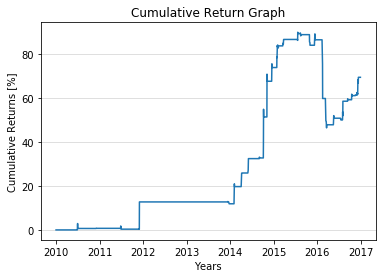



Cumulative Return =  69.44%


-----------------Daily Returns Statistics--------------------




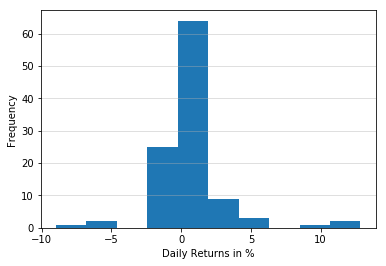

Average Daily Returns =  0.53%
Standard Deviation of Daily Returns =  0.67%
Skewness of Daily Returns =  8.99
Kurtosis of Daily Returns =  211.03


-------------------Annualized Performance---------------------


No. of years =  7.0
Annualized Return =  7.82%
Sharpe Ratio =  0.78


-----------------Maximum Drawdown and Recovery-------------------


Start Date: 2015-07-23 00:00:00
End Date: 2016-03-21 00:00:00
Maximum Drawdown: 22.91%
Not recovered yet


C:\Users\Public\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


In [15]:
#Cummulative Return
cum_returns = port['Cummulative Return']
cum_return = cum_returns[port.index[-1]]
dates = port['Date']
print ("------------------------PnL Graph---------------------------")
plt.plot(dates,(cum_returns-1)*100)
plt.xlabel("Years")
plt.ylabel("Cumulative Returns [%]")
plt.title("Cumulative Return Graph")
plt.grid(axis='y', alpha=0.5)
plt.show()
print('\n')
print("Cumulative Return = ","{:.2%}".format(cum_return-1))

#print mean,std,shape
print ('\n')
print('-----------------Daily Returns Statistics--------------------')
print ('\n')
returns1 = port['Daily Return']
zer = 0
tot = 0
drs = 0
for index, row in port.iterrows():
    tot = tot + 1
    if (port.loc[index, 'Daily Return']==0):
        zer = zer + 1
mean = returns1.sum()/(tot-zer)
x = (returns1[returns1!=0]*100).tolist()
##print(x)
plt.hist(x)
plt.xlabel("Daily Returns in %")
plt.ylabel("Frequency")
#plt.axis([-10, 12, 0, 40])
plt.grid(axis='y', alpha=0.5)
plt.show()
print('Average Daily Returns = ',"{:.2%}".format(mean))
std = returns1.std()
print('Standard Deviation of Daily Returns = ',"{:.2%}".format(std))
skewness = skew(returns1)
print('Skewness of Daily Returns = ',round(skewness,2))
kurt = kurtosis(returns1)
print('Kurtosis of Daily Returns = ',round(kurt,2))

print ('\n')
print ('-------------------Annualized Performance---------------------')
print ('\n')
tds = pd.Timedelta(dates.max()-dates.min())
no_of_days = tds.days
no_of_years =  float(no_of_days)/float(365)
print('No. of years = ', round(no_of_years,1))


#Annualized Return
annualized_return = ((cum_return)**(1/float(no_of_years)))-1
print("Annualized Return = ","{:.2%}".format(annualized_return))

#Sharpe Ratio
drfr = ((1+risk_free_rate)**(1/365))-1
sharpe_ratio = (mean-drfr)/(std)
print("Sharpe Ratio = ",round(sharpe_ratio,2))

print ('\n')
print ('-----------------Maximum Drawdown and Recovery-------------------')
print ('\n')

cr = maxdrawdown(port)

In [1]:
%cd C:\Users\Aravind Ganesan\Documents\PythonCSVFiles

C:\Users\Aravind Ganesan\Documents\PythonCSVFiles


In [23]:
dates.type()

AttributeError: 'Series' object has no attribute 'type'

In [16]:
cr

0       1.000000
1       1.000000
2       1.000000
3       1.000000
4       1.000000
5       1.000000
6       1.000000
7       1.000000
8       1.000000
9       1.000000
10      1.000000
11      1.000000
12      1.000000
13      1.000000
14      1.000000
15      1.000000
16      1.000000
17      1.000000
18      1.000000
19      1.000000
20      1.000000
21      1.000000
22      1.000000
23      1.000000
24      1.000000
25      1.000000
26      1.000000
27      1.000000
28      1.000000
29      1.000000
          ...   
1726    1.611012
1727    1.614336
1728    1.612828
1729    1.613343
1730    1.613343
1731    1.613343
1732    1.613343
1733    1.613343
1734    1.613343
1735    1.624947
1736    1.617154
1737    1.615631
1738    1.621151
1739    1.617622
1740    1.658646
1741    1.683776
1742    1.667206
1743    1.694382
1744    1.694382
1745    1.694382
1746    1.694382
1747    1.694382
1748    1.694382
1749    1.694382
1750    1.694382
1751    1.694382
1752    1.694382
1753    1.6943